# Pedigree exploration

The following code is exploratory, with a simple WF model. The sections below include models that forbid cousin marriages.

In [1]:
import itertools
from collections import defaultdict
import msprime
import tskit
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# From msprime documentation
from matplotlib import pyplot as plt
import networkx as nx

def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

The function below addes a generation, given the indices of parents, under a WF model assuming no sexes.

In [3]:
def add_generation_wf(pb, N, t, parents=None, samples=False, pself=None):
    if pself is None:
        # WF model has pself = 1/N
        pself = 1 / N
    curr_gen_ids = []
    for _ in range(N):
        if parents is None:
            indiv = pb.add_individual(time=t)
        else:
            if np.random.rand() < pself:
                # Selfing event
                indiv_parents = np.array(
                    2 * [np.random.choice(parents)]).astype("int32")
            else:
                # Different parents
                indiv_parents = np.random.choice(
                    parents, size=2, replace=False).astype("int32")
            indiv = pb.add_individual(
                time=t, parents=indiv_parents, is_sample=samples)
        curr_gen_ids.append(indiv)
    return curr_gen_ids

In [4]:
N = 5
gens = 5
r = 1e-8
L = 1e6

In [5]:
pb = msprime.PedigreeBuilder()
curr_gen = None
for gen in range(gens)[::-1]:
    samples = False
    if gen == 0:
        samples = True
    curr_gen = add_generation_wf(pb, N, gen, parents=curr_gen, samples=samples, pself=0)

In [6]:
pedigree_tables = pb.finalise(sequence_length=L)
assert len(pedigree_tables.individuals) == gens * N

In [7]:
ped_ts = msprime.sim_ancestry(
    initial_state=pedigree_tables,
    model="fixed_pedigree",
    recombination_rate=r,
)

In [8]:
ped_ts

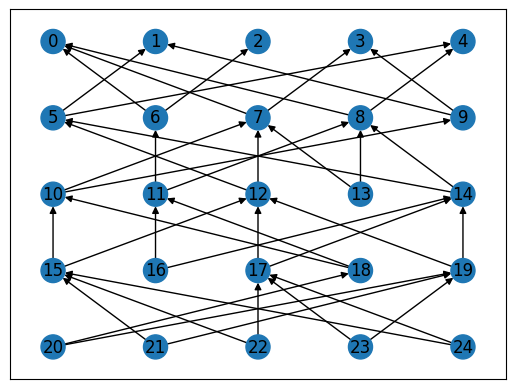

In [9]:
draw_pedigree(ped_ts)

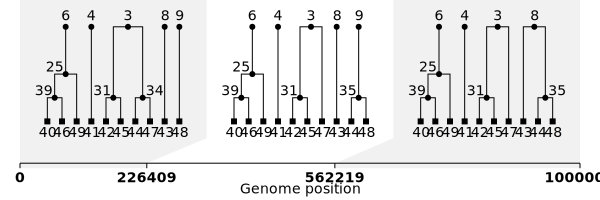

In [10]:
ped_ts.draw_svg()

In [11]:
final_ts = msprime.sim_ancestry(
    initial_state=ped_ts, model="dtwf",
    population_size=N,
    recombination_rate=r,
    random_seed=12,
)

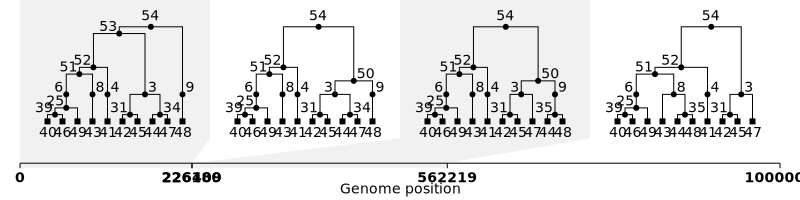

In [12]:
final_ts.draw_svg()

In [13]:
segments = ped_ts.ibd_segments(store_segments=True, max_time=2)

In [14]:
print(segments)

╔════════════════════════╗
║IdentitySegments        ║
╠══════════════╤═════════╣
║Parameters:   │         ║
║max_time      │        2║
║min_span      │        0║
║store_pairs   │    False║
║store_segments│     True║
║Results:      │         ║
║num_segments  │        6║
║total_span    │5000000.0║
╚══════════════╧═════════╝



# Pedigree simulation, monogamy and two sexes (sib-pairs allowed)

In [15]:
def add_generation_mf_monogamous(pb, N, t, males=None, females=None, samples=False):
    offspring_ms = []
    offspring_fs = []
    sibs = defaultdict(list)
    if males is None and females is None:
        # if no males/females given, initialize pedigree with first generation
        for _ in range(N):
            indiv = pb.add_individual(time=t)
            # with p=0.5, offspring is male/female
            if np.random.rand() < 0.5:
                offspring_ms.append(indiv)
            else:
                offspring_fs.append(indiv)
    else:
        if len(males) == 0 or len(females) == 0:
            raise ValueError("only one sex --- extinction!")
            return
        parent_pairs = list(zip(
            np.random.permutation(males), np.random.permutation(females)))
        for _ in range(N):
            indiv_parents = parent_pairs[np.random.randint(len(parent_pairs))]
            indiv = pb.add_individual(
                time=t, parents=indiv_parents, is_sample=samples)
            # with p=0.5, offspring is male/female
            if np.random.rand() < 0.5:
                offspring_ms.append(indiv)
            else:
                offspring_fs.append(indiv)
            if samples:
                sibs[indiv_parents].append(indiv)
    return offspring_ms, offspring_fs, sibs

In [16]:
def get_num_tot_ibd(ped_ts, sibs, max_time=1, min_span=0):
    num_seg = []
    tot_ibd = []
    for parents, offspring in sibs.items():
        if len(offspring) < 2:
            continue
        for o1, o2 in itertools.combinations(offspring, 2):
            nodes1 = ped_ts.individual(o1).nodes
            nodes2 = ped_ts.individual(o2).nodes
            segments = ped_ts.ibd_segments(between=[nodes1, nodes2], 
                store_segments=True, min_span=min_span, max_time=max_time)
            num_seg.append(segments.num_segments)
            tot_ibd.append(segments.total_span)
    return num_seg, tot_ibd

# Pedigree simulation, two sexes and forbid marriages to nth degree

In [17]:
def draw_parent_pairs(males, females, families, degree):
    max_degree = min(degree, max(families[males[0]].keys()))
    females_left = np.random.permutation(females)
    pairs = []
    for m in np.random.permutation(males):
        if len(females_left) == 0:
            continue
        for f in females_left:
            found_mate = 1
            for deg in range(max_degree + 1):
                if len(families[m][deg].intersection(families[f][deg])) > 0:
                    found_mate = 0
                    break
            if found_mate:
                break
        if found_mate:
            pairs.append([m, f])
            females_left = np.delete(females_left, females_left == f)
    return pairs

def add_generation_nth_cousins(
    pb, N, t, males=None, females=None, samples=False, families=None, degree=1
):
    # families stores the 0th, 1st, up to degree-th parents/grandparents
    # siblings are 0th degree
    offspring_ms = []
    offspring_fs = []
    sibs = defaultdict(list)
    if males is None and females is None and families is None:
        # if no males/females given, initialize pedigree with first generation
        for _ in range(N):
            indiv = pb.add_individual(time=t)
            # with p=0.5, offspring is male/female
            if np.random.rand() < 0.5:
                offspring_ms.append(indiv)
            else:
                offspring_fs.append(indiv)
        offspring_families = None
    else:
        offspring_families = {}
        if len(males) == 0 or len(females) == 0:
            raise ValueError("only one sex --- extinction!")
        if families is None:
            # randomly pair males and females, as there is no pedigree info yet
            parent_pairs = list(zip(
                np.random.permutation(males), np.random.permutation(females)))
        else:
            parent_pairs = draw_parent_pairs(males, females, families, degree)
        all_parents = np.array(parent_pairs).flatten()
        assert len(all_parents) == len(set(all_parents))
        for _ in range(N):
            indiv_parents = parent_pairs[np.random.randint(len(parent_pairs))]
            indiv = pb.add_individual(
                time=t, parents=indiv_parents, is_sample=samples)
            # with p=0.5, offspring is male/female
            if np.random.rand() < 0.5:
                offspring_ms.append(indiv)
            else:
                offspring_fs.append(indiv)
            # get offspring family info
            offspring_families[indiv] = {0: set(indiv_parents)}
            if families is not None:
                for p in indiv_parents:
                    for k, v in families[p].items():
                        if k >= degree + 1:
                            # no need to track more distant relationships
                            continue
                        offspring_families[indiv].setdefault(k + 1, set())
                        offspring_families[indiv][k + 1] = offspring_families[indiv][k + 1].union(v)
            if samples:
                sibs[tuple(indiv_parents)].append(indiv)
    return offspring_ms, offspring_fs, offspring_families, sibs

For runs of homozygosity, we look at distributions of IBD within each individual, rather than across individuals.

In [18]:
def get_roh(ped_ts, max_time=None, min_span=0):
    num_seg = []
    tot_ibd = []
    counted = 0
    for i in ped_ts.individuals():
        if ped_ts.node(i.nodes[0]).time != 0:
            # only want final generation individuals
            continue
        counted += 1
        nodes = i.nodes
        segments = ped_ts.ibd_segments(within=nodes, 
            store_segments=True, min_span=min_span, max_time=max_time)
        num_seg.append(segments.num_segments)
        tot_ibd.append(segments.total_span)
    return num_seg, tot_ibd

In [19]:
N0 = 1000
Nf = 5000
gens = 40

def size_func(t, N0, Nf, gens):
    # get the population size at a given generation
    r = np.log(Nf / N0)
    Nt = N0 * np.exp(r * t / gens)
    return np.rint(Nt).astype(int)

L = 1e8
r = 1e-8

Below, we'll run a set of simulations that forbit sibling (degree=0), first cousin (1), second or third cousin marriages. For each, we'll run a number of simulations, and store the number of IBD segments within individuals (corresponding to ROH regions) and their total lengths.

In [20]:
n_reps = 20

data = {}
for degree in range(4):
    print("DEGREE=", degree)
    n_list = np.zeros(0, dtype=int)
    L_list = np.zeros(0)
    for rep in range(n_reps):
        print("on rep", rep, end="... ")
        # build pedigree
        pb = msprime.PedigreeBuilder()
        males = None
        females = None
        families = None
        for i, gen in enumerate(range(gens+1)[::-1]):
            samples = False
            if gen == 0:
                samples = True
            Nt = size_func(i, N0, Nf, gens)
            males, females, families, sibs = add_generation_nth_cousins(
                pb, Nt, gen, males=males, females=females, samples=samples,
                families=families, degree=degree)
        
        pedigree_tables = pb.finalise(sequence_length=L)
        
        # simulate 22 1M chromosomes
        ped_ts = msprime.sim_ancestry(
            initial_state=pedigree_tables,
            model="fixed_pedigree",
            recombination_rate=r,
            num_replicates=22,
        )
        
        # get segments and total Ls
        num_segs = []
        Ltots = []
        print("done with", end=" ")
        for i, ts in enumerate(ped_ts):
            num_seg, Ltot = get_roh(ts, min_span=50000)
            num_segs.append(np.array(num_seg))
            Ltots.append(np.array(Ltot))
            print(i+1, end=", ")
    
        print("compiling")
        num_seg = np.sum(num_segs, axis=0)
        Ltot = np.sum(Ltots, axis=0)
        assert len(num_seg) == Nf
    
        n_list = np.concatenate((n_list, num_seg))
        L_list = np.concatenate((L_list, Ltot))
    data[degree] = {"n": n_list, "L": L_list}

DEGREE= 0
on rep 0... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 1... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 2... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 3... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 4... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 5... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 6... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 7... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, compiling
on rep 8... done with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, c

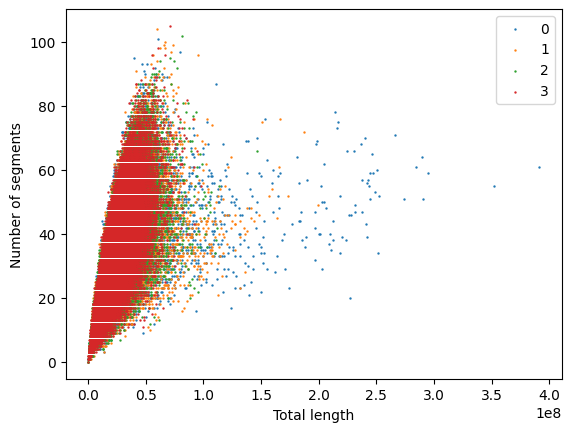

In [21]:
for i in range(4):
    plt.scatter(data[i]["L"], data[i]["n"], marker=".", label=i, s=2)
plt.xlabel("Total length")
plt.ylabel("Number of segments")
plt.legend();

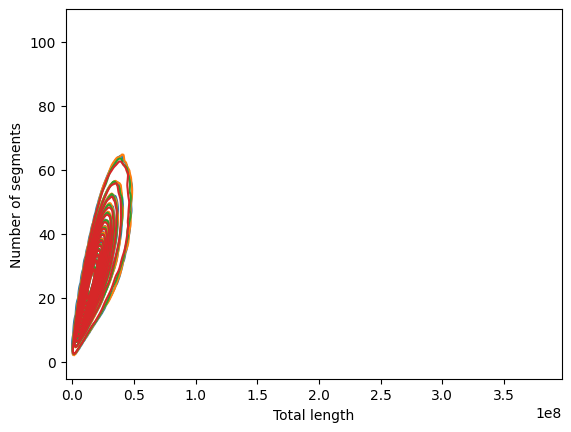

In [22]:
for i in range(4):
    sns.kdeplot(x=data[i]["L"], y=data[i]["n"], levels=15, label=i)
plt.xlabel("Total length")
plt.ylabel("Number of segments")
plt.show()